In [1]:
from SingleAgent import SingleRLAgent
from MultiAgentEnvironment import MultiAgentEnvironment
import matplotlib.pyplot as plt
from RLTrainer import demonstrate_model
from DQN_Agent_Single import DQN_Agent_Single
from DQN_Agent_Double import DQN_Agent_Double
import pytorch_utils as ptu
from QNets import N_Concat_CNNs
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, update_display
import ipywidgets as widgets
import imageio
import time
import random
import numpy as np
from collections import namedtuple 
from collections import deque
import pickle
import torch
#!pip3 install pickle5
import pickle5 as pickle
import seaborn as sb
import os
from pathlib import Path
import math
from scipy.stats import wasserstein_distance
from scipy.spatial import distance
from scipy.stats.stats import pearsonr
!pip install dtw-python
import dtw

Device set to : cpu


/home/silvester/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [61]:
def hamming_distance(string1, string2):
    dist_counter = 0
    for n in range(len(string1)):
        if string1[n] != string2[n]:
            dist_counter += 1
    return dist_counter

def rotate(l, n, dim=0):
    if dim==0:
        return l[n:] + l[:n]
    elif dim==1:
        return l

def minimum_hamming_distance(vec1, vec2):
    min_rot = -1
    min_hamming_dist = 10000
    for rot_n in range(len(vec1)):
        rot_vec2 = rotate(vec2, rot_n)
        hamming_dist = hamming_distance(vec1, rot_vec2)
        if(hamming_dist < min_hamming_dist):
            min_hamming_dist = hamming_dist
            min_rot = rot_n
    return min_hamming_dist, min_rot

In [60]:
vec_ones_1D = np.ones(10)
vec_zeros_1D = np.zeros(10)
vec_ones_2D = np.ones((4,4))
vec_zeros_2D = np.zeros((4,4))

print(vec_ones_1D.ndim)
print(vec_ones_2D.ndim)
print(vec_ones_2D.ravel())
print(len(vec_ones_1D))

print('hamming-dist: ', hamming_distance(vec_ones_2D, vec_zeros_2D))

1
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
10
hamming-dist:  16


In [37]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return distance[row][col]

In [38]:
def dtwPlotTwoWay(d, xts=None, yts=None,
                  offset=0,
                  ts_type="l",
                  match_indices=None,
                  match_col="gray",
                  xlab="Index",
                  ylab="Query value", ax=None):
    # IMPORT_RDOCSTRING dtwPlotTwoWay
    #import matplotlib.pyplot as plt
    from matplotlib import collections  as mc
    if xts is None or yts is None:
        try:
            xts = d.query
            yts = d.reference
        except:
            raise ValueError("Original timeseries are required")
    # ytso = yts + offset
    offset = -offset
    maxlen = max(len(xts), len(yts))
    times = np.arange(maxlen)
    xts = np.pad(xts,(0,maxlen-len(xts)),"constant",constant_values=np.nan)
    yts = np.pad(yts,(0,maxlen-len(yts)),"constant",constant_values=np.nan)

    if ax is None:
        fig, ax = plt.subplots()
        if offset != 0:
            ax2 = ax.twinx()
            ax2.tick_params('y', colors='b')
        else:
            ax2 = ax
    else:
            ax2 = ax.twinx()
            ax2.tick_params('y', colors='b')

    ax.plot(times, xts, color='k')
    ax2.plot(times, yts)

    ql, qh = ax.get_ylim()
    rl, rh = ax2.get_ylim()

    if offset > 0:
        ax.set_ylim(ql - offset, qh)
        ax2.set_ylim(rl, rh + offset)
    elif offset < 0:
        ax.set_ylim(ql, qh - offset)
        ax2.set_ylim(rl + offset, rh)

    # https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
    if match_indices is None:
        idx = np.linspace(0, len(d.index1) - 1)
    elif not hasattr(match_indices, "__len__"):
        idx = np.linspace(0, len(d.index1) - 1, num=match_indices)
    else:
        idx = match_indices
    idx = np.array(idx).astype(int)
    col = []
    for i in idx:
        col.append([(d.index1[i], xts[d.index1[i]]),
                    (d.index2[i], -offset + yts[d.index2[i]])])
    lc = mc.LineCollection(col, linewidths=1, linestyles=":", colors=match_col)
    ax.add_collection(lc)

In [59]:
vec = list(np.arange(16))


print(vec_shift)
vec = a.reshape((4,4))
print('vec= \n',vec)
print('Manhatten-distance: ', 0)
print('Euclidean-distance: ', 0)
print('')

vec_rot_left_0_down_1 = np.roll(vec, 1, axis=0) #vec[n:] + vec[:n]
print('vec_rot_left_0_down_1= \n',vec_rot_left_0_down_1)
print('Manhatten-distance: ', 1)
print('Euclidean-distance: ', 1)
print('')

vec_rot_left_0_down_2 = np.roll(vec, 2, axis=0) #vec[n:] + vec[:n]
print('vec_rot_left_0_down_2= \n',vec_rot_left_0_down_2)
print('Manhatten-distance: ', 2)
print('Euclidean-distance: ', 2)
print('')

print('...')

vec_rot_left_1_down_0 = np.roll(vec, 1, axis=1) #vec[n:] + vec[:n]
print('vec_rot_left_1_down_0= \n',vec_rot_left_1_down_0)
print('Manhatten-distance: ', 1)
print('Euclidean-distance: ', 1)
print('')

vec_rot_left_1_down_1 = np.roll(vec_rot_left_1_down_0, 1, axis=0) #vec[n:] + vec[:n]
print('vec_rot_left_1_down_1= \n',vec_rot_left_1_down_1)
print('Manhatten-distance: ', 2)
print('Euclidean-distance: ', 1.4142)
print('')

print('...')

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1]
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
vec= 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
Manhatten-distance:  0
Euclidean-distance:  0

vec_rot_left_0_down_1= 
 [[12 13 14 15]
 [ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
Manhatten-distance:  1
Euclidean-distance:  1

vec_rot_left_0_down_2= 
 [[ 8  9 10 11]
 [12 13 14 15]
 [ 0  1  2  3]
 [ 4  5  6  7]]
Manhatten-distance:  2
Euclidean-distance:  2

...
vec_rot_left_1_down_0= 
 [[ 3  0  1  2]
 [ 7  4  5  6]
 [11  8  9 10]
 [15 12 13 14]]
Manhatten-distance:  1
Euclidean-distance:  1

vec_rot_left_1_down_1= 
 [[15 12 13 14]
 [ 3  0  1  2]
 [ 7  4  5  6]
 [11  8  9 10]]
Manhatten-distance:  2
Euclidean-distance:  1.4142

...


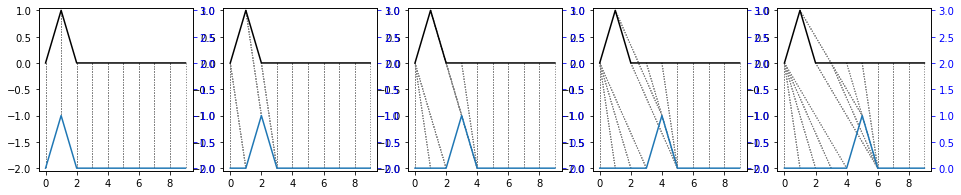

In [8]:
n_objects = 5
vec_ref = [0.]*10
vec_ref[1] = 1.

fig, axs = plt.subplots(nrows=1, ncols=n_objects, figsize=(16,3))
axn = []
#plt.figure(1)

#plt.figure(figsize=(10, 1.8))


for n in range(1, n_objects+1):
    vecn = [0.]*10
    vecn[n] = 1.
    dtwPlotTwoWay(dtw.dtw(vec_ref, vecn, keep_internals=True),offset=-2, ax=axs[n-1])

    

0.0
0.0
0.0

0.0
0.0
0.0

[1 1 1 1 1 1 1 1 1]
[2 1 1 3 1 1 1 1 1 1]
[2 2 2 1 1 3 3 3 1 1 1 1]

[0 1 2 3 4 5 6 7 8 9]
[0 0 1 2 3 4 5 6 7 8 9]
[0 0 0 0 1 2 3 4 5 6 7 8 9]

Step pattern recursion:
 g[i,j] = min(
     g[i-1,j-1] + 2 * d[i  ,j  ] ,
     g[i  ,j-1] +     d[i  ,j  ] ,
     g[i-1,j  ] +     d[i  ,j  ] ,
 ) 

Normalization hint: N+M

Step pattern recursion:
 g[i,j] = min(
     g[i-1,j-1] + 2 * d[i  ,j  ] ,
     g[i  ,j-1] +     d[i  ,j  ] ,
     g[i-1,j  ] +     d[i  ,j  ] ,
 ) 

Normalization hint: N+M

Step pattern recursion:
 g[i,j] = min(
     g[i-1,j-1] + 2 * d[i  ,j  ] ,
     g[i  ,j-1] +     d[i  ,j  ] ,
     g[i-1,j  ] +     d[i  ,j  ] ,
 ) 

Normalization hint: N+M



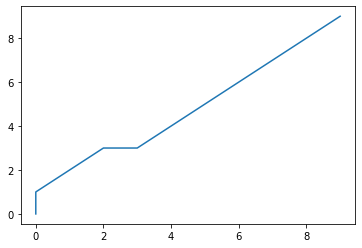

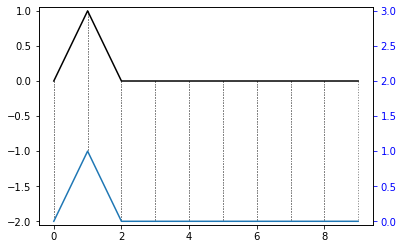

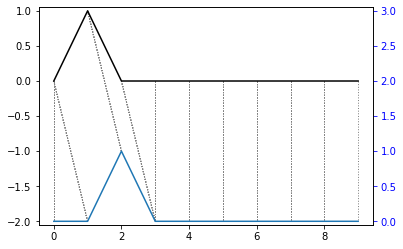

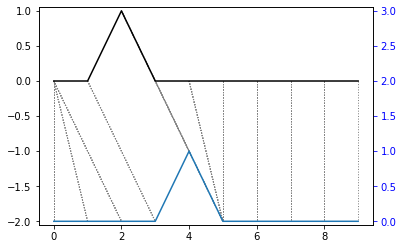

<AxesSubplot:>

In [9]:
vec1 = [0.]*10
vec2 = [0.]*10
vec3 = [0.]*10
vec1[1] = 1.
vec2[2] = 1.
vec3[4] = 1.

align_11 = dtw.dtw(vec1, vec1, keep_internals=True)
align_12 = dtw.dtw(vec1, vec2, keep_internals=True)
align_13 = dtw.dtw(vec1, vec3, keep_internals=True)

print(align_11.distance)
print(align_12.distance)
print(align_13.distance)
print('')
print(align_11.normalizedDistance)
print(align_12.normalizedDistance)
print(align_13.normalizedDistance)
print('')
print(align_11.stepsTaken)
print(align_12.stepsTaken)
print(align_13.stepsTaken)
print('')
print(align_11.index1)
print(align_12.index1)
print(align_13.index1)
print('')
print(align_11.stepPattern)
print(align_12.stepPattern)
print(align_13.stepPattern)

plt.plot(align_12.index1, align_12.index2) 

dtw.dtw(vec1, vec1, keep_internals=True)\
    .plot(type="twoway",offset=-2)

dtw.dtw(vec1, vec2, keep_internals=True)\
    .plot(type="twoway",offset=-2)

dtw.dtw(vec2, vec3, keep_internals=True)\
    .plot(type="twoway",offset=-2)


In [9]:
vec1 = [0.]*10
vec2 = [0.]*10
vec3 = [0.]*10
vec1[0] = 1.
vec2[1] = 1.
vec3[2] = 1.

print('vec1: ', [int(i) for i in vec1])
print('vec2: ', [int(i) for i in vec2])
print('vec3: ', [int(i) for i in vec3])
print("")

vec_11 = np.stack([vec1, vec1])
vec_12 = np.stack([vec1, vec2])
vec_13 = np.stack([vec1, vec3])
#corry = np.corrcoef(vec3)[0, 1]

pearson_corry_11 = pearsonr(vec1, vec1)[0]
pearson_corry_12 = pearsonr(vec1, vec2)[0]
pearson_corry_13 = pearsonr(vec1, vec3)[0]
print('Pearson-Correlation:')
print('   (vec1,vec1)', pearson_corry_11)
print('   (vec1,vec2)', pearson_corry_12)
print('   (vec1,vec3)', pearson_corry_13)

cross_corry_11 = np.corrcoef(vec1, vec1)[0, 1]
cross_corry_12 = np.corrcoef(vec1, vec2)[0, 1]
cross_corry_13 = np.corrcoef(vec1, vec3)[0, 1]
print('Cross-Correlation:')
print('   (vec1,vec1)', cross_corry_11)
print('   (vec1,vec2)', cross_corry_12)
print('   (vec1,vec3)', cross_corry_13)

wass_corry_12 = wasserstein_distance(vec1, vec2)
wass_corry_13 = wasserstein_distance(vec1, vec3)
print('Wasserstein-Distance:')
print('   (vec1,vec2)', wass_corry_12)
print('   (vec1,vec3)', wass_corry_13)

mink_corry_12 = distance.minkowski(vec1, vec2)
mink_corry_13 = distance.minkowski(vec1, vec3)
print('Minkowski-Distance:')
print('   (vec1,vec2)', mink_corry_12)
print('   (vec1,vec3)', mink_corry_13)

ham_dist_12 = hamming_distance(vec1, vec2)
ham_dist_13 = hamming_distance(vec1, vec3)
print('Hamming-Distance:')
print('   (vec1,vec2)', ham_dist_12)
print('   (vec1,vec3)', ham_dist_13)

leven_dist_12 = hamming_distance(vec1, vec2)
leven_dist_13 = hamming_distance(vec1, vec3)
print('Levenshtein-Distance:')
print('   (vec1,vec2)', leven_dist_12)
print('   (vec1,vec3)', leven_dist_13)

min_ham_dist_12 = minimum_hamming_distance(vec1, vec2)
min_ham_dist_13 = minimum_hamming_distance(vec1, vec3)
print('Levenshtein-Distance:')
print('   (vec1,vec2)', min_ham_dist_12)
print('   (vec1,vec3)', min_ham_dist_13)

vec1:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
vec2:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
vec3:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Pearson-Correlation:
   (vec1,vec1) 0.9999999999999996
   (vec1,vec2) -0.11111111111111116
   (vec1,vec3) -0.11111111111111116
Cross-Correlation:
   (vec1,vec1) 1.0
   (vec1,vec2) -0.11111111111111109
   (vec1,vec3) -0.11111111111111109
Wasserstein-Distance:
   (vec1,vec2) 0.0
   (vec1,vec3) 0.0
Minkowski-Distance:
   (vec1,vec2) 1.4142135623730951
   (vec1,vec3) 1.4142135623730951
Hamming-Distance:
   (vec1,vec2) 2
   (vec1,vec3) 2
Levenshtein-Distance:
   (vec1,vec2) 2
   (vec1,vec3) 2
Levenshtein-Distance:
   (vec1,vec2) (0, 1)
   (vec1,vec3) (0, 2)


In [39]:
data_dir = '/home/silvester/programming/rl-single-agent-numbers/counting-agents/src/../data/'

In [10]:
data_dir = '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/src/../data/'

In [45]:
exp_type_list = ['static_no_curriculum', 'temporal_no_curriculum', 'temporal_abacus_no_curriculum', 'temporal_abacus_2D_no_curriculum']
nice_exp_type_dict = {'static_final': 'Static', 
                      'temporal_final': 'Temporal', 
                      'temporal_abacus_1D_final': 'Temporal+1D-constraints', 
                      'temporal_abacus_2D_final': 'Temporal+2D-constraints'}
exp_type_dir_list = [data_dir + exp_type for exp_type in exp_type_list]

In [41]:
exp_type_list = ['temporal_final', 'temporal_abacus_1D_final', 'temporal_abacus_2D_final']
nice_exp_type_dict = {'static_final': 'Static', 
                      'temporal_final': 'Temporal', 
                      'temporal_abacus_1D_final': 'Temporal+1D-constraints', 
                      'temporal_abacus_2D_final': 'Temporal+2D-constraints'}
exp_type_dir_list = [data_dir + exp_type for exp_type in exp_type_list]

In [40]:
exp_type_list = ['static_final', 'temporal_final', 'temporal_abacus_1D_final', 'temporal_abacus_2D_final']
nice_exp_type_dict = {'static_final': 'Static', 
                      'temporal_final': 'Temporal', 
                      'temporal_abacus_1D_final': 'Temporal+1D-constraints', 
                      'temporal_abacus_2D_final': 'Temporal+2D-constraints'}
exp_type_dir_list = [data_dir + exp_type for exp_type in exp_type_list]

In [41]:
# Count how many full runs there have been for each setup
full_count_for_each_setup = {exp_type: 0 for exp_type in exp_type_list}

for exp_type in exp_type_list:
    exp_type_dir = data_dir + exp_type
    exp_dir_list = os.listdir(exp_type_dir)
    for exp_dir in exp_dir_list:
        master_episodes_file_dir = exp_type_dir + '/' + exp_dir + '/master_episodes.pkl'
        #print(master_episodes_file_dir)
        if(os.path.exists(master_episodes_file_dir)):
            with open(master_episodes_file_dir, 'rb') as f:
                master_episodes = pickle.load(f)
                #print(master_episodes)
            if(len(list(master_episodes.keys())) > 0):
                if(max(master_episodes.keys()) == 9):
                    full_count_for_each_setup[exp_type] += 1
                #print(exp_type_dir + '/' + exp_dir)
            
print(full_count_for_each_setup)

{'static_final': 5, 'temporal_final': 4, 'temporal_abacus_1D_final': 5, 'temporal_abacus_2D_final': 5}


In [10]:
ext_img_shape = (img_height * agenty.ext_shape[1], img_height * agenty.ext_shape[0])
ext_repr_img = Image.fromarray(agenty.ext_repr.externalrepresentation * 255).resize(ext_img_shape, resample=0)
ext_repr_img = utils.add_grid_lines(ext_repr_img, agenty.ext_repr.externalrepresentation)
ext_repr_img = ext_repr_img.transpose(Image.TRANSPOSE)
annotaty = str(agenty.n_objects)
ext_repr_img = utils.annotate_below(ext_repr_img, annotaty).convert('RGB')
dimmy = 1 if agenty.ext_shape[1] == 1 else 2
if (dimmy==1):
    space_img = Image.fromarray(np.ones(agenty.ext_shape[1], dtype=np.uint8)*255).resize((img_height, img_height//4), resample=0)
    ext_repr_img = utils.concat_imgs_h([ext_repr_img, space_img], dist=0)
else:
    space_img = Image.fromarray(np.ones(agenty.ext_shape[1], dtype=np.uint8)*255).resize((img_height//4, img_height), resample=0)
    ext_repr_img = utils.concat_imgs_h([ext_repr_img, space_img], dist=0)

#ext_repr_img = np.asarray( ext_repr_img ).astype(np.uint8).transpose([2,0,1])
ext_repr_imgs[agenty.n_objects].append(ext_repr_img)



total_imgs_tensor = [np.expand_dims(np.asarray(ext_repr_imgs[i][0]).astype(np.uint8).transpose([2, 0, 1]), axis=0) for i in range(0, env.max_objects + 1)]
total_imgs = [ext_repr_imgs[i][0] for i in range(0, env.max_objects + 1)]

min_examples = 10000
for i in range(0, env.max_objects + 1):
    if(len(ext_repr_imgs[i]) < min_examples):
        min_examples = len(ext_repr_imgs[i])
example_repr_for_all_numbers_list = []
show_n_examples = min(min_examples, 10)
for j in range(show_n_examples):
    j_example_repr_for_all_numbers = [ext_repr_imgs[i][j] for i in range(0, env.max_objects + 1)]
    j_example_repr_for_all_numbers = utils.concat_imgs_h(j_example_repr_for_all_numbers, dist=50)
    example_repr_for_all_numbers_list.append(j_example_repr_for_all_numbers)

all_example_repr = utils.concat_imgs_v(example_repr_for_all_numbers_list, dist=50) #.resize(env.max_objects*100,show_n_examples*100*10)

if(env.dimmy==1):
    total_imgs_tensor = np.concatenate(total_imgs_tensor, axis=2)
    total_imgs = utils.concat_imgs_v(total_imgs, dist=10)

NameError: name 'img_height' is not defined

exp_type /home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/src/../data/temporal_abacus_1D_final
[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]
{0: [0, 0, 0, 0, 0], 1: [9, 1, 1, 1, 9], 2: [8, 2, 2, 2, 8], 3: [7, 3, 3, 3, 7], 4: [6, 4, 4, 4, 6], 5: [5, 5, 5, 5, 5], 6: [4, 6, 6, 6, 4], 7: [3, 7, 7, 7, 3], 8: [2, 8, 8, 8, 2], 9: [1, 9, 9, 9, 1]}
list(all_token_positions.keys()):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


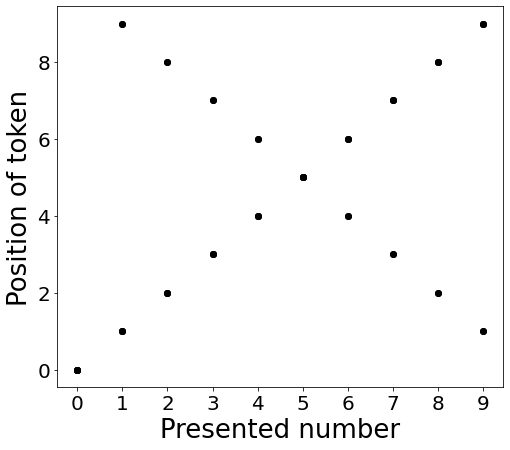

In [22]:
# Plot token-positions for multiple runs and setup: abacus-1D
exp_type = data_dir + 'temporal_abacus_1D_final'
print('exp_type', exp_type)

fig, ax = plt.subplots(figsize=(8,7))
max_episode = 0
all_token_positions = {i: [] for i in range(0,10)}

token_positions_mean = {}
token_positions_std = {}


#exp_dir_list = os.listdir(exp_type)
exp_dir_list = [d for d in os.listdir(exp_type) if os.path.isdir(os.path.join(exp_type, d))]


for exp_dir in exp_dir_list:
    master_episodes_file_dir = exp_type + '/' + exp_dir + '/ext_representations/external_representations.pkl'
    with open(master_episodes_file_dir, 'rb') as f:
        ext_repr = pickle.load(f)
        token_positions = get_token_positions_of_reprs(ext_repr)
    print(token_positions)
    for i in range(len(token_positions)):
        all_token_positions[i].append(token_positions[i]-token_positions[0])

for i in all_token_positions.keys():
    token_positions_mean[i] = np.mean(all_token_positions[i])#
    token_positions_std[i] = np.std(all_token_positions[i])

max_numbers = [k for k in all_token_positions.keys()]
#episodes = [v for v in all_master_episodes_dict.values()]


#master_episodes_mean = {i: master_episodes[i] for i in master_episodes_dict.keys()}
print(all_token_positions)
#for i in all_token_positions.keys():
# ax.boxplot(all_token_positions.values(), showmeans=True, 
#                       meanprops={"marker":"o",
#                        "markerfacecolor":"black", 
#                        "markeredgecolor":"black",
#                       "markersize":"10"})

for i in range(len(all_token_positions.keys())):
    ax.scatter(len(all_token_positions[i])*[i], all_token_positions[i], color='black')

#ax.boxplot(master_episodes_mean_dict)
print('list(all_token_positions.keys()): ', list(all_token_positions.keys()))
ax.set_xticks(list(all_token_positions.keys()))
#current_max = master_episodes_mean_dict[-1]
#if(current_max>max_episode):
#    max_episode = current_max
#    ax.set_ylim(0, master_episodes_mean_dict[-1]+master_episodes_mean_dict[-1]//2)
ax.set_xlabel('Presented number', fontsize=26)
ax.set_ylabel('Position of token', fontsize=26)
ax.tick_params(labelsize=20)
file_path = exp_type + '/token_positions.pdf'
fig.savefig(file_path)

In [17]:
list(all_token_positions.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [108]:
exp_type_list = ['temporal_final', 'temporal_abacus_1D_final', 'temporal_abacus_2D_final']
nice_exp_type_dict = {'temporal_final': 'Temporal', 
                      'temporal_abacus_1D_final': 'Temporal+1D-constraints', 
                      'temporal_abacus_2D_final': 'Temporal+2D-constraints'}
exp_type_dir_list = [data_dir + exp_type for exp_type in exp_type_list]

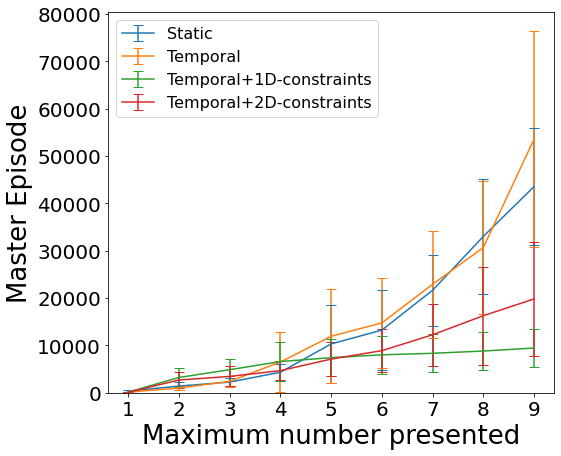

In [23]:
### new
### Plot Master-episodes for all setups and runs

fig, ax = plt.subplots(figsize=(8,7))

max_episode = 0

for exp_type in exp_type_list:
    exp_type_dir = data_dir + exp_type
    exp_dir_list = os.listdir(exp_type_dir)
    all_master_episodes_dict = {i: [] for i in range(1,10)}
    master_episodes_mean_std = {i: [] for i in range(1,10)}

    for exp_dir in exp_dir_list:
        master_episodes_file_dir = exp_type_dir + '/' + exp_dir + '/master_episodes.pkl'
        #print(master_episodes_file_dir)
        if(os.path.exists(master_episodes_file_dir)):
            with open(master_episodes_file_dir, 'rb') as f:
                master_episodes = pickle.load(f)
            for i in master_episodes.keys():
                all_master_episodes_dict[i].append(master_episodes[i])
            
    
    master_episodes_mean_dict = [np.mean(all_master_episodes_dict[i]) for i in all_master_episodes_dict.keys()]
    master_episodes_mean_std = [np.std(all_master_episodes_dict[i]) for i in all_master_episodes_dict.keys()]

    max_numbers = [k for k in all_master_episodes_dict.keys()]
    #episodes = [v for v in all_master_episodes_dict.values()]
    
    
    #master_episodes_mean = {i: master_episodes[i] for i in master_episodes_dict.keys()}
    
    ax.errorbar(range(1,10), 
                master_episodes_mean_dict, 
                yerr=master_episodes_mean_std, 
                solid_capstyle='projecting', 
                capsize=5,
                label=nice_exp_type_dict[exp_type])
    ax.legend(fontsize=16)
    #ax.boxplot(master_episodes_mean_dict)
    ax.set_xticks(max_numbers)
    current_max = master_episodes_mean_dict[-1]
    if(current_max>max_episode):
        max_episode = current_max
        ax.set_ylim(0, master_episodes_mean_dict[-1]+master_episodes_mean_dict[-1]//2)
    ax.set_xlabel('Maximum number presented', fontsize=26)
    ax.set_ylabel('Master Episode', fontsize=26)
    ax.tick_params(labelsize=20)
    file_path = data_dir + '/all_master_episodes.pdf'
    fig.savefig(file_path)

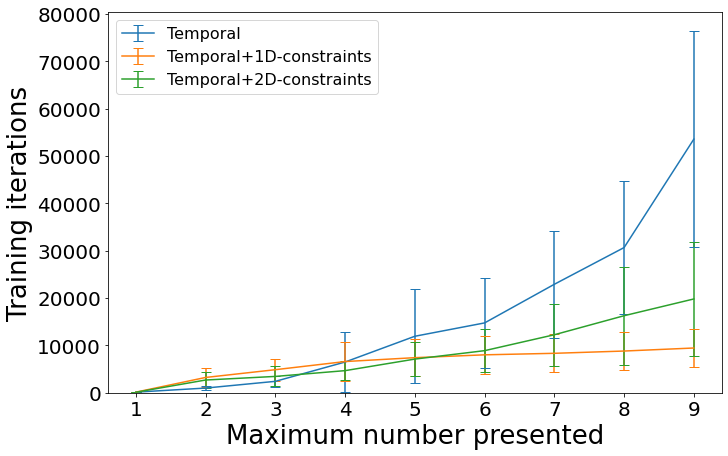

In [45]:
### Plot Master-episodes for all setups and runs

fig, ax = plt.subplots(figsize=(11,7))

max_episode = 0

for exp_type in exp_type_list:
    exp_type_dir = data_dir + exp_type
    exp_dir_list = os.listdir(exp_type_dir)
    all_master_episodes_dict = {i: [] for i in range(1,10)}
    master_episodes_mean_std = {i: [] for i in range(1,10)}

    for exp_dir in exp_dir_list:
        master_episodes_file_dir = exp_type_dir + '/' + exp_dir + '/master_episodes.pkl'
        #print(master_episodes_file_dir)
        if(os.path.exists(master_episodes_file_dir)):
            with open(master_episodes_file_dir, 'rb') as f:
                master_episodes = pickle.load(f)
            for i in master_episodes.keys():
                all_master_episodes_dict[i].append(master_episodes[i])
            
    
    master_episodes_mean_dict = [np.mean(all_master_episodes_dict[i]) for i in all_master_episodes_dict.keys()]
    master_episodes_mean_std = [np.std(all_master_episodes_dict[i]) for i in all_master_episodes_dict.keys()]

    max_numbers = [k for k in all_master_episodes_dict.keys()]
    #episodes = [v for v in all_master_episodes_dict.values()]
    
    
    #master_episodes_mean = {i: master_episodes[i] for i in master_episodes_dict.keys()}
    
    ax.errorbar(range(1,10), 
                master_episodes_mean_dict, 
                yerr=master_episodes_mean_std, 
                solid_capstyle='projecting', 
                capsize=5,
                label=nice_exp_type_dict[exp_type])
    ax.legend(fontsize=16)
    #ax.boxplot(master_episodes_mean_dict)
    ax.set_xticks(max_numbers)
    current_max = master_episodes_mean_dict[-1]
    if(current_max>max_episode):
        max_episode = current_max
        ax.set_ylim(0, master_episodes_mean_dict[-1]+master_episodes_mean_dict[-1]//2)
    ax.set_xlabel('Maximum number presented', fontsize=26)
    ax.set_ylabel('Training iterations', fontsize=26)
    ax.tick_params(labelsize=20)
    file_path = data_dir + '/all_master_episodes.pdf'
    fig.savefig(file_path,bbox_inches='tight')

In [75]:
def hamming_distance(vec1, vec2):
    dist_counter = 0
    vec1, vec2 = vec1.ravel(), vec2.ravel() 
    for n in range(vec1.size):
        if vec1[n] != vec2[n]:
            dist_counter += 1
    
    return dist_counter

def rotate(l, n, m=0, dim=1):
    if dim==1:
        return np.roll(l, n, axis=0)
    elif dim==2:
        l_shift_y = np.roll(l, n, axis=0)
        l_shift_xy = np.roll(l_shift_y, m, axis=1)
        return l_shift_xy

def minimum_hamming_distance(vec1, vec2):
    min_rot = -1
    min_hamming_dist = 10000
    #print("vec1.ndim: ", vec1.ndim)
    if(vec1.ndim==1):
        for rot_n in range(len(vec1)):
            rot_vec2 = rotate(vec2, rot_n)
            hamming_dist = hamming_distance(vec1, rot_vec2)
            if(hamming_dist < min_hamming_dist):
                min_hamming_dist = hamming_dist
                min_rot = rot_n
    elif(vec1.ndim==2):
        for rot_n, rot_m in np.ndindex(vec1.shape):
            rot_vec2 = rotate(vec2, rot_n, m=rot_m, dim=2)
            hamming_dist = hamming_distance(vec1, rot_vec2)
            if(hamming_dist < min_hamming_dist):
                min_hamming_dist = hamming_dist
                min_rot = rot_n + rot_m
                #print("min_hamming_dist: ", min_hamming_dist)
    return min_hamming_dist, min_rot

np.max(corr_matrix):  1.55
np.max(corr_matrix):  5.15
np.max(corr_matrix):  9.25
np.max(corr_matrix):  1.8125
np.max(corr_matrix):  0.0
np.max(corr_matrix):  5.8
np.max(corr_matrix):  4.4
np.max(corr_matrix):  3.3


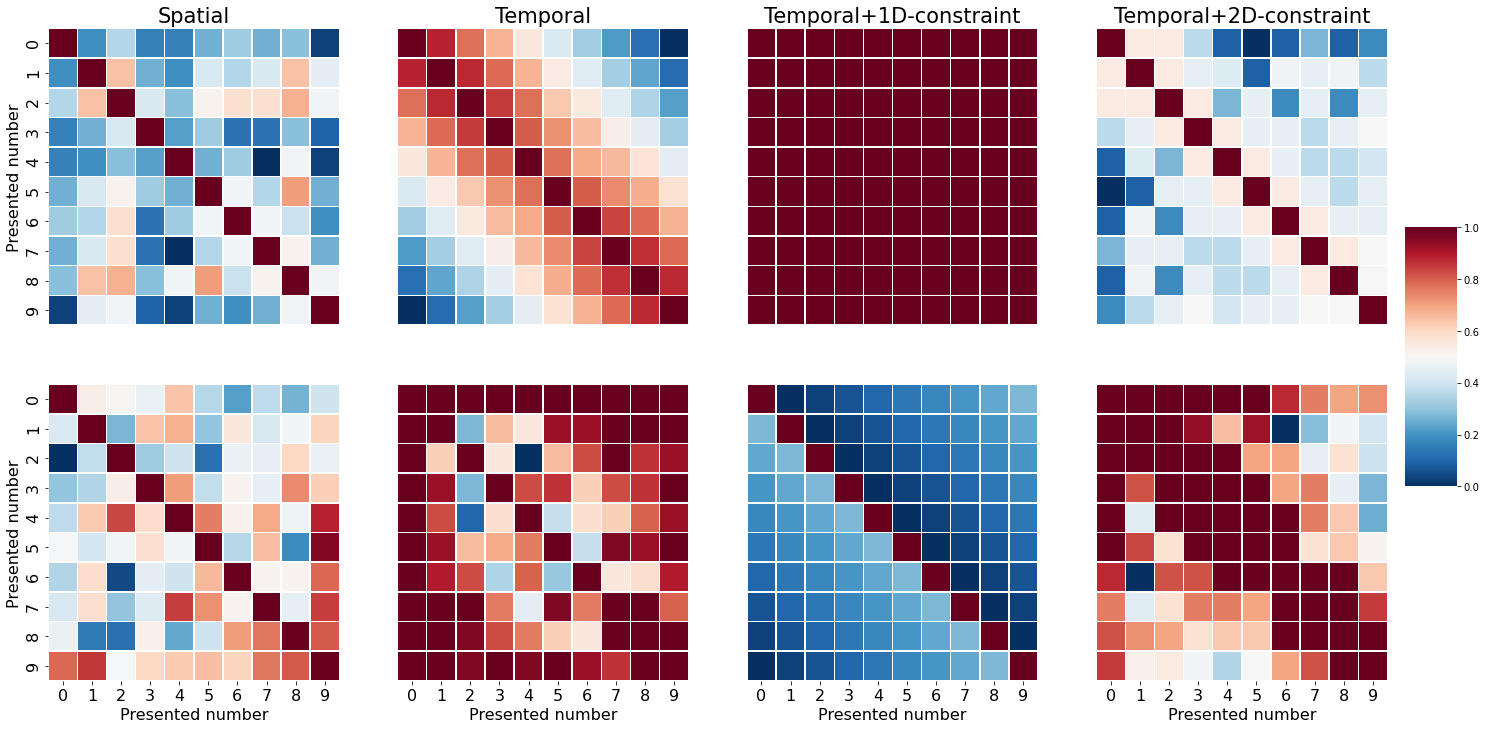

In [76]:
def get_avg_corr_matrix(exp_type, Isrot_dist=False):
    corr_matrix_list = []
    master_episodes_list = []

    exp_dir_list = os.listdir(exp_type)

    for exp_dir in exp_dir_list:
       master_episodes_file_dir = exp_type + '/' + exp_dir + '/master_episodes.pkl'
       if(os.path.exists(master_episodes_file_dir)):
            with open(master_episodes_file_dir, 'rb') as f:
                master_episodes = pickle.load(f)
            if(max(master_episodes.keys()) == 9):
                ext_repr_file_dir = exp_type + '/' + exp_dir + '/ext_representations/external_representations.pkl'
                with open(ext_repr_file_dir, 'rb') as f:
                    ext_repr = pickle.load(f)
                    corr_matrix = create_external_repr_correlation_matrix(ext_repr, Isrot_dist=Isrot_dist)
   
                    corr_matrix_list.append(corr_matrix)
                    #print(corr_matrix)
   
    corr_matrix = np.mean(corr_matrix_list, axis=0)
    print('np.max(corr_matrix): ', np.max(corr_matrix))
    if(np.max(corr_matrix)>1e-8):
        corr_matrix = np.ones(corr_matrix.shape) - corr_matrix/np.max(corr_matrix)
    else:
        corr_matrix = np.ones(corr_matrix.shape)

    return corr_matrix

#file_path = exp_type_dir + '/' + exp_type + '_external_repr_correlation.svg'


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
#cbar_ax_1 = fig.add_axes([.91, .555, .03, .3])
#cbar_ax_2 = fig.add_axes([.91, .145, .03, .3])
cbar_ax_1 = fig.add_axes([.91, .35, .03, .3])
cbar_ax_2 = cbar_ax_1

exp_type = 'static_final'
exp_type_dir = data_dir + exp_type
corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=False)
plot_external_repr_correlation(corr_matrix, task_description='Spatial', file_path=None, ax=axs[0, 0], show_legend=False, show_x=False)

corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=True)
plot_external_repr_correlation(corr_matrix, task_description='', file_path=None, ax=axs[1, 0], show_legend=False)

exp_type = 'temporal_final'
exp_type_dir = data_dir + exp_type
corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=False)
plot_external_repr_correlation(corr_matrix, task_description='Temporal', file_path=None, ax=axs[0, 1], show_legend=False, show_x=False, show_y=False)

corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=True)
plot_external_repr_correlation(corr_matrix, task_description='', file_path=None, ax=axs[1, 1], show_legend=False, show_x=True, show_y=False)

exp_type = 'temporal_abacus_1D_final'
exp_type_dir = data_dir + exp_type
corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=False)
plot_external_repr_correlation(corr_matrix, task_description='Temporal+1D-constraint', file_path=None, ax=axs[0, 2]
, show_legend=True, show_x=False, show_y=False,cbar_ax=cbar_ax_1)

corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=True)
plot_external_repr_correlation(corr_matrix, task_description='', file_path=None, ax=axs[1, 2], show_legend=True, show_x=True, show_y=False,cbar_ax=cbar_ax_2)


exp_type = 'temporal_abacus_2D_final'
exp_type_dir = data_dir + exp_type
corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=False)
plot_external_repr_correlation(corr_matrix, task_description='Temporal+2D-constraint', file_path=None, ax=axs[0, 3]
, show_legend=True, show_x=False, show_y=False,cbar_ax=cbar_ax_1)

corr_matrix = get_avg_corr_matrix(exp_type_dir, Isrot_dist=True)
plot_external_repr_correlation(corr_matrix, task_description='', file_path=None, ax=axs[1, 3], show_legend=True, show_x=True, show_y=False,cbar_ax=cbar_ax_2)



file_path = data_dir + 'quant_analysis_all_4.svg'
#fig.tight_layout()
fig.savefig(file_path)


In [51]:
# collect all master-episodes and correlation matrices from each folder
#for exp_type in exp_type_list:

#exp_type = 'static_final'
exp_type = 'temporal_final'
#exp_type = 'temporal_abacus_1D_final'
#exp_type = 'temporal_abacus_2D_final'

exp_type_dir = data_dir + exp_type


def get_avg_corr_matrix(exp_type):
    corr_matrix_list = []
    master_episodes_list = []

    exp_dir_list = os.listdir(exp_type)

    for exp_dir in exp_dir_list:
        master_episodes_file_dir = exp_type + '/' + exp_dir + '/master_episodes.pkl'
        if(os.path.exists(master_episodes_file_dir)):
            with open(master_episodes_file_dir, 'rb') as f:
                master_episodes = pickle.load(f)
            if(max(master_episodes.keys()) == 9):
                ext_repr_file_dir = exp_type + '/' + exp_dir + '/ext_representations/external_representations.pkl'
                with open(ext_repr_file_dir, 'rb') as f:
                    ext_repr = pickle.load(f)
                corr_matrix = create_external_repr_correlation_matrix(ext_repr)
                
                corr_matrix_list.append(corr_matrix)
                #print(corr_matrix)
    
    corr_matrix = np.mean(corr_matrix_list, axis=0)
    
    
    return corr_matrix

corr_matrix = get_avg_corr_matrix(exp_type_dir)
file_path = exp_type_dir + '/' + exp_type + '_external_repr_correlation.svg'
plot_external_repr_correlation(corr_matrix, task_description='', file_path=file_path, show_x=True)
    

ValueError: operands could not be broadcast together with shapes (10,) (0,) 

In [73]:

def plot_and_save_master_episodes(master_episodes, file_path):
    max_numbers = [k for k in master_episodes]
    episodes = [v for v in master_episodes.values()]
    fig, ax = plt.subplots(figsize=(16,14))
    ax.scatter(max_numbers, episodes, s=100, color='black')
    ax.set_xticks(max_numbers)
    ax.set_ylim(0, episodes[-1]+episodes[-1]//10)
    ax.set_xlabel('Maximum number presented', fontsize=26)
    ax.set_ylabel('Master Episode', fontsize=26)
    ax.tick_params(labelsize=20)
    fig.savefig(file_path)

# If ext_tool==Abacus: calculate spatial structure:
# position of token correlate with the presented number
def get_token_positions_of_reprs(ext_repr):
    one_repr_for_each_number = [repr[0] for repr in ext_repr.values()]
    numbers = [k for k,v in ext_repr.items()]
    repr_size = ext_repr[0][0].size
    pos_of_token_for_each_number = [np.where(repry == 1)[0][0] for repry in one_repr_for_each_number]
    
    return pos_of_token_for_each_number

def plot_token_position_of_reprs(numbrs, pos_of_token_for_each_number, yerr=None,file_path=None):
    fig, ax = plt.subplots(figsize=(16,14))
    ax.errorbar(numbers, pos_of_token_for_each_number, yerr=yerr, s=100, color='black')
    ax.set_xticks(numbers)
    ax.set_yticks(range(repr_size))
    #ax.set_ylim(0, episodes[-1]+episodes[-1]//10)
    ax.set_xlabel('Presented number', fontsize=26)
    ax.set_ylabel('Position of token', fontsize=26)
    ax.tick_params(labelsize=20)
    fig.savefig(file_path)
    
def create_external_repr_correlation_matrix(ext_repr, Isrot_dist=False):

    numbers = list(ext_repr.keys())
    max_objects = numbers[-1]
    first,second = max_objects, max_objects
    var_len = first
    range_var_len = range(var_len)
    combined = [(f,s) for f in numbers for s in numbers]


    corr_matrix_list = []
    for example_i in range(4):
        corr_matrix = np.empty([var_len+1,var_len+1])
        for (i,j) in combined:
            vec1 = 2*np.array(ext_repr[i][example_i] )-1  #2*x-1 (binary to bipolar)
            vec2 = 2*np.array(ext_repr[j][example_i] )-1
            #vec1 = vec1 + np.random.normal(0, .001, vec1.shape)
            #vec2 = vec2 + np.random.normal(0, .001, vec2.shape)
            vec3 = np.stack([vec1, vec2])[:, :, 0]
            #print('vec1', vec1[:,0])
            #print('vec1', vec1[:,0])
            #corry = dtw.dtw(vec1[:,0], vec2[:,0]).normalizedDistance
            #corry = pearsonr(vec1[:,0], vec2[:,0])[0]
            #corry = np.correlate(vec1[:,0], vec2[:,0])
            #corry = np.corrcoef(vec3)[0, 1]
            #corry = np.cov(vec3)[0, 1]
            if(vec1.shape[1]==1):
                vec1 = vec1[:,0]
                vec2 = vec2[:,0]
            corry, rot_dist = minimum_hamming_distance(vec1, vec2)
            if(Isrot_dist):
                corry = rot_dist
            #print(corry)
            #if(math.isnan(corry)):
             #print('vec1: ', vec1)
             #print('vec2: ', vec2)
            #    corry=0
            corr_matrix[i,j] = corry
        corr_matrix_list.append(corr_matrix)
    corr_matrix = np.mean(corr_matrix_list, axis=0)

    return corr_matrix

def plot_external_repr_correlation(corr_matrix, task_description, file_path=None, ax=None, show_legend=True,cbar_ax=None, show_x=True, show_y=True, vmax=None):

    title=task_description
    max_objects = corr_matrix[0].size-1
    tick_labels = [str(i) for i in range(0,max_objects+1)] #later all keys in DICT of ext_representation
    if(ax is None):
        fig, ax = plt.subplots(figsize=(16,14))
        #ax = plt.axes()
        fontsize=35
    else:
        fontsize=16
        fig = ax.get_figure()
    if(cbar_ax is None):
        cbar_ax=ax
    if(vmax is None):
        vmax = 1.
    sb.heatmap(corr_matrix,
             xticklabels=tick_labels,
             yticklabels=tick_labels,
             cmap='RdBu_r',
             linewidth=0.5,
               ax=ax,
           vmin=0,
           vmax=vmax,
           annot=False,
           cbar=show_legend,
            cbar_ax=cbar_ax if show_legend else None)

    ax.set_title(title, fontsize=fontsize+5)
    ax.set_xlabel('Presented number', fontsize=fontsize)
    ax.set_ylabel('Presented number', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    #file_path = exp_dir + '/ext_repr_correlation.svg'
    if(show_x==False):
        #ax.tick_params(labelbottom=False)
        ax.get_xaxis().set_visible(False)
    if(show_y==False):
        #ax.tick_params(labelbottom=False)
        ax.get_yaxis().set_visible(False)

    if(file_path is not None):
     print(file_path)
     fig.savefig(file_path)


In [50]:
vec1 = np.ones((4,4))
#vec2 = vec1 + np.ones(vec1.shape)*0.2
vec2  = vec1 + np.random.normal(0, .01, vec1.shape)
print(vec2)

[[1.00713801 1.0065299  0.99020305 1.0042711 ]
 [1.00618557 1.0084863  0.99492573 1.00993633]
 [0.99625905 1.01948152 0.99271889 1.00075647]
 [1.00718724 1.00348456 0.99635491 1.01447617]]


In [53]:
vec1 = np.array(ext_repr[2][0] )
vec2 = np.array(ext_repr[2][0] )
vec3 = np.stack([vec1, vec2])[:, :, 0]
print(vec3.shape)
corry = np.corrcoef(vec3)[0, 1]

#print(vec1)
#print(vec2)
print(corry)

(2, 9)
1.0


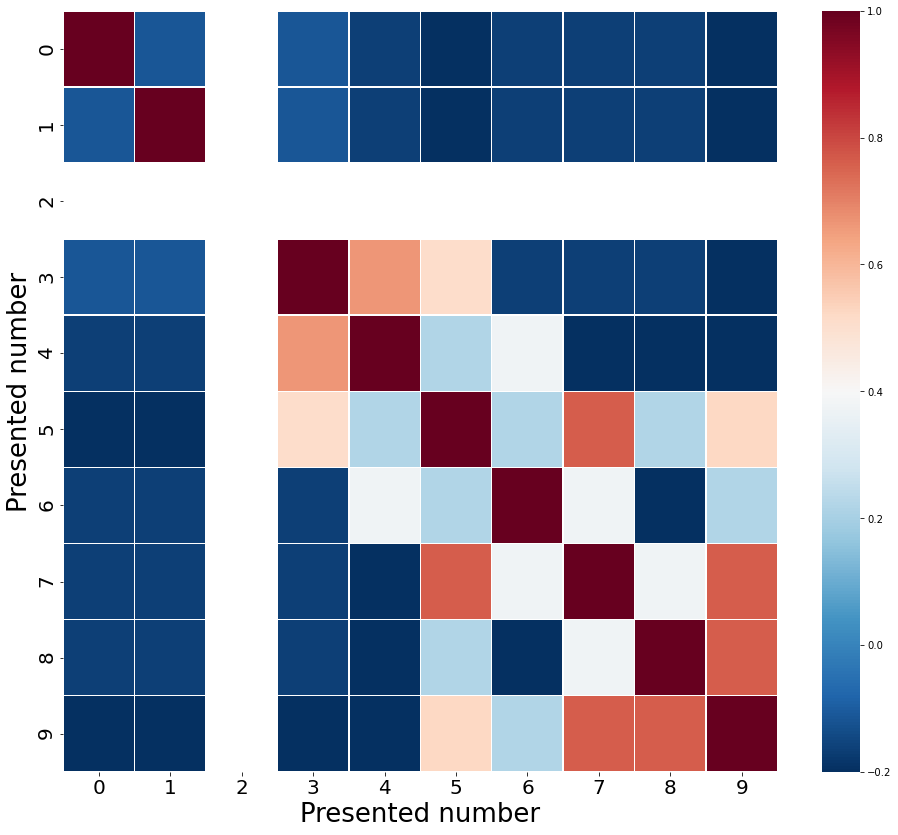

In [13]:
exp_dir = '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/data/static_1/classify_WriteCoord_spatial_1_to_9_22-09-2021_18-33-16'
#exp_dir = '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/data/temporal_1/classify_WriteCoord_temporal_1_to_9_22-09-2021_18-33-16'
#exp_dir = '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/data/temporal_abacus_1D_1/classify_Abacus_temporal_1_to_9_22-09-2021_18-33-16'
#exp_dir = '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/data/temporal_abacus_2D_1/classify_Abacus_temporal_1_to_9_22-09-2021_18-33-16'


# Load external representations
file_dir = exp_dir + '/ext_representations/external_representations.pkl'
with open(file_dir, 'rb') as f:
    ext_repr = pickle.load(f)

# Plot and save token positions of external representations if task == Abacus
#file_path = exp_dir + '/token_positions.svg'
#plot_and_save_token_positions_of_reprs(ext_repr, file_path=file_path)

# Plot and save correlations between the external representations
file_path = exp_dir + '/ext_repr_correlation.svg'
plot_and_save_external_repr_correlation(ext_repr, task_description='', file_path=file_path)





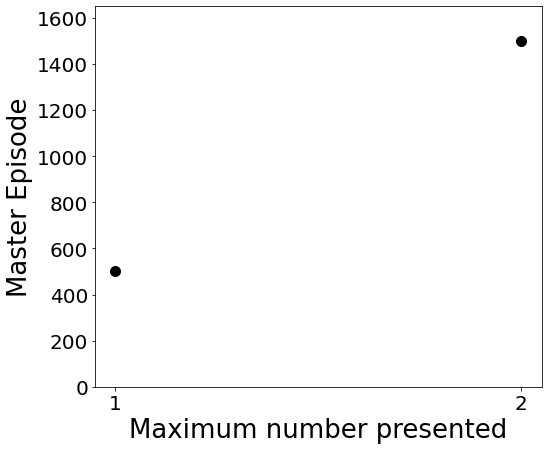

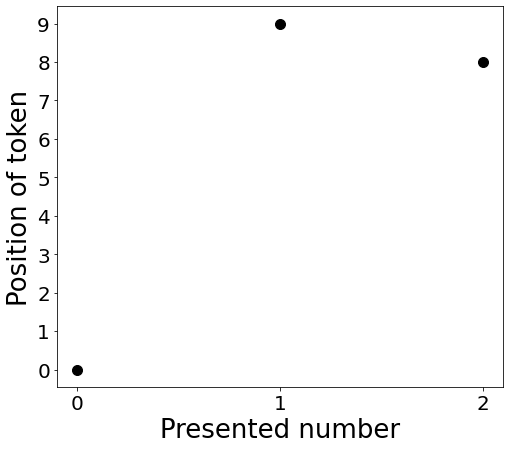

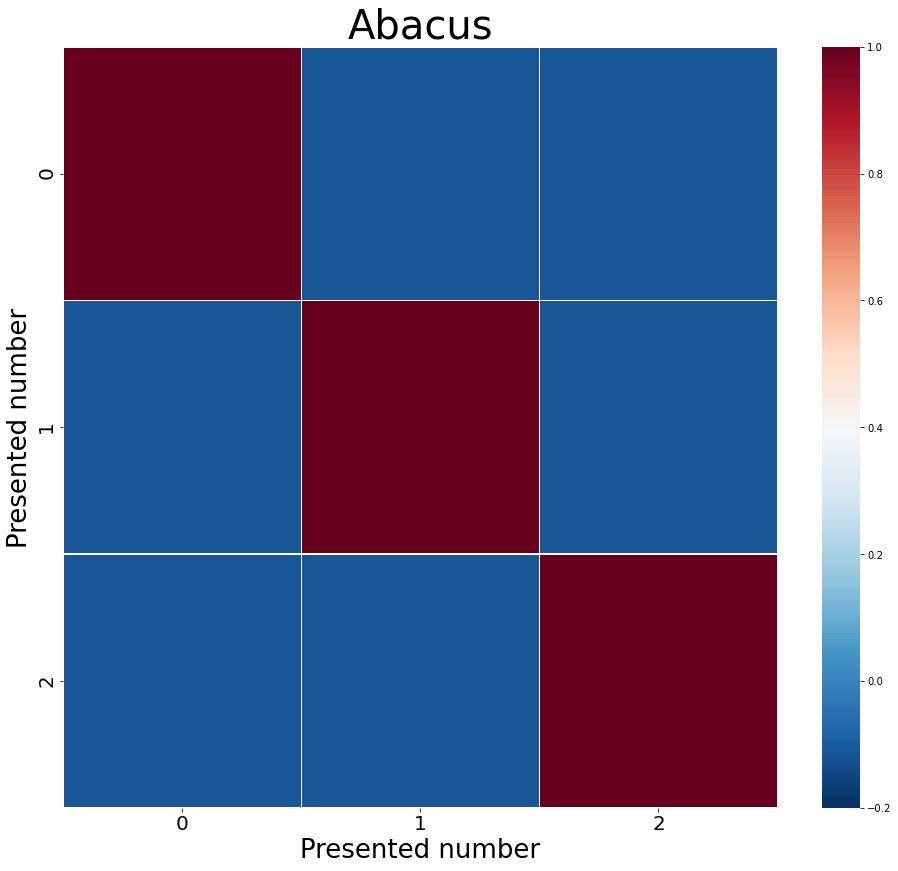

In [155]:
# Get example representations from right directory
#exp_dir = data_dir + 'classify_Abacus_temporal_2_to_9_20-09-2021_16-04-37'
#exp_dir = data_dir + 'classify_WriteCoord_temporal_2_to_9_21-09-2021_14-08-22'
#exp_dir = data_dir + 'classify_WriteCoord_temporal_1_to_2_21-09-2021_19-09-56'
#exp_dir = data_dir + 'static_1/classify_Abacus_temporal_1_to_2_22-09-2021_16-44-32'
#exp_dir = data_dir + 'static_1/classify_Abacus_temporal_1_to_2_22-09-2021_16-44-32'

exp_dir = data_dir + 'static_1/classify_WriteCoord_spatial_1_to_9_22-09-2021_18-33-16'

# Load master episodes
file_dir = exp_dir + '/master_episodes.pkl'
with open(file_dir, 'rb') as f:
    master_episodes = pickle.load(f)
    
# Plot and save master episodes
file_path = exp_dir + '/master_episodes.svg'
plot_and_save_master_episodes(master_episodes, file_path)


# Load external representations
file_dir = exp_dir + '/ext_representations/external_representations.pkl'
with open(file_dir, 'rb') as f:
    ext_repr = pickle.load(f)

# Plot and save token positions of external representations if task == Abacus
file_path = exp_dir + '/token_positions.svg'
plot_and_save_token_positions_of_reprs(ext_repr, file_path=file_path)

# Plot and save correlations between the external representations
file_path = exp_dir + '/ext_repr_correlation.svg'
plot_and_save_external_repr_correlation(ext_repr, task_description='Abacus', file_path=file_path)

In [ ]:
def get_correlation_matrix(df_test,within_class,within_class_instance,check_class,layer,plot=False,ax=None ):
    first,second=df_test[check_class].unique(),df_test[check_class].unique()
    var_len = len(first)
    range_var_len = range(var_len)

    combined = [(f,s) for f in range_var_len for s in range_var_len]

    corr_matrix = np.empty([var_len,var_len ])
    for (i,j) in combined: 
        i_class_instance=df_test[check_class].unique()[i]
        j_class_instance=df_test[check_class].unique()[j]
        try:
            vec1 = get_node_activity_vector(df_test, within_class, within_class_instance, check_class, i_class_instance, layer).values[0]
        except IndexError:
            print(within_class, within_class_instance, check_class, i_class_instance, layer)
        vec2 = get_node_activity_vector(df_test, within_class, within_class_instance, check_class, j_class_instance, layer).values[0]
        #corry = df_test[(df_test[within_class]==within_class_instance) & (df_test[check_class]==i_class_instance) & (df_test['layer']==layer)].node_activities.corr(df_test[(df_test[within_class]==within_class_instance) & (df_test[check_class]==j_class_instance) & (df_test['layer']==layer)].node_activities, method='pearson')
        corry = np.corrcoef(vec1, vec2)[0, 1]
        corr_matrix[i,j] = corry
    
        
    title=task_description 
    tick_labels = df_test[check_class].unique()
    if(ax is None):
        ax = plt.axes()
    sb.heatmap(corr_matrix, 
                xticklabels=tick_labels,
                yticklabels=tick_labels,
                cmap='RdBu_r',
                linewidth=0.5,
                  ax=ax,
              vmin=-0.2,
              vmax=1.0,
              annot=False)

    ax.set_title(title)
    
    
    return corr_matrix

Working with max  3  objects


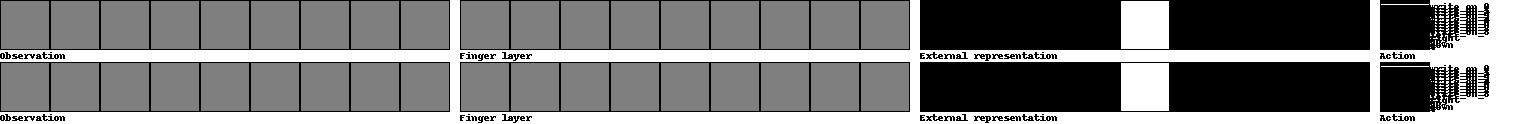

In [3]:
##############
## Static Environment Image
###################

obs_ext_shape = (4,1)
agent_params = {
    'single_or_multi_agent': 'multi',
    'task': 'classify',
    'external_repr_tool': 'WriteCoord',
    'observation': 'spatial',
    'max_objects': 3,
    'obs_shape': obs_ext_shape,
    'ext_shape': obs_ext_shape,
    'max_episode_length': 8,
    'curriculum_learning': False
}



if(agent_params['single_or_multi_agent'] == 'multi'):
    env = MultiAgentEnvironment(agent_params)
    env.agents[0].check_reward = False
if(agent_params['single_or_multi_agent'] == 'single'):
    env = SingleRLAgent(agent_params)
    env.check_reward = False
    
#env.max_episode_length = 7
#env.reset()
display(env.render(), display_id='model_demo')
env.step(['down', 'write_on_2'])
update_display(env.render(), display_id='model_demo')

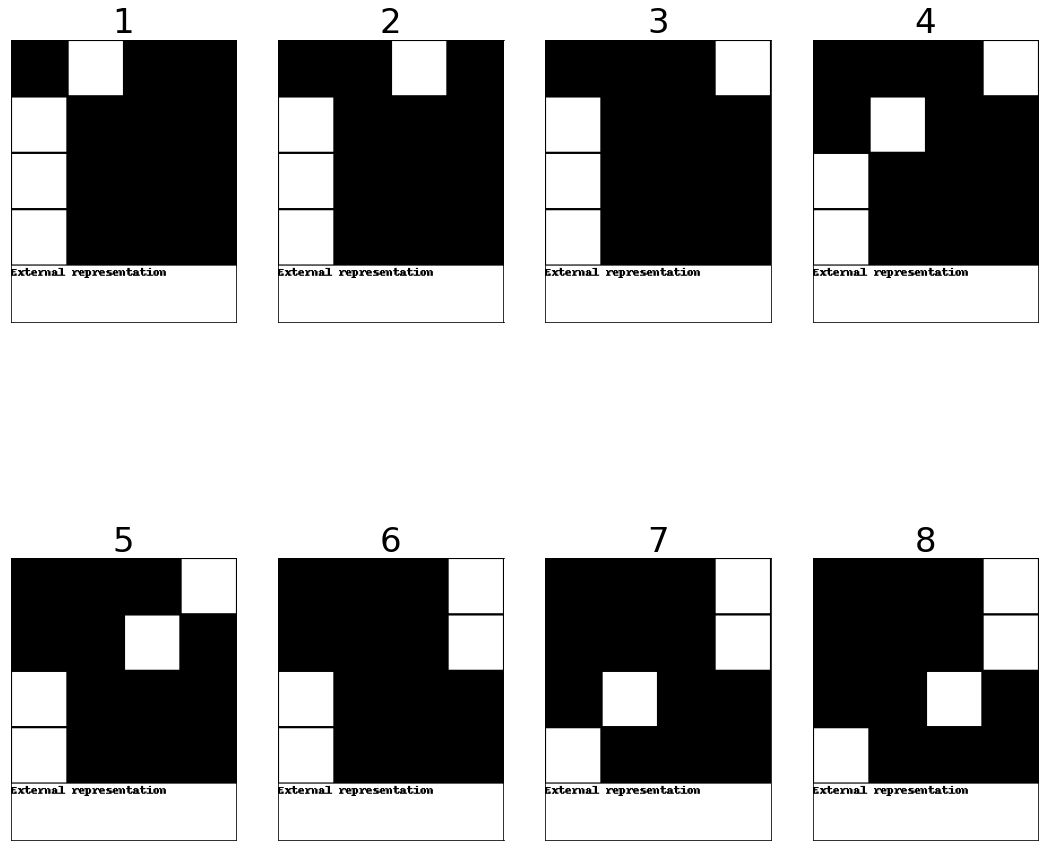

In [55]:
##############
## Plot grid of hand-crafted external representations
##########################################


##############
## Dynamic Environment Demo with Sequence of Actions
###################


agent_params = {
    'single_or_multi_agent': 'single',
    'task': 'classify',
    'external_repr_tool': 'Abacus',
    'observation': 'temporal',
    'max_objects': 2,
    'obs_dim': 4,
    'obs_shape': (4,4),
    'ext_shape': (4,4),
    'IsSubmitButton': False,
    'max_episode_length': 8,
    'curriculum_learning': False
}



if(agent_params['single_or_multi_agent'] == 'multi'):
    env = MultiAgentEnvironment(agent_params)
    env.agents[0].check_reward = False
if(agent_params['single_or_multi_agent'] == 'single'):
    env = SingleRLAgent(agent_params)
    env.check_reward = False
#env.max_episode_length = 7
env.reset()
#display(env.render(), display_id='model_demo')
grid_width = 4
grid_height = 2
fig, axs = plt.subplots(grid_height, grid_width,figsize=(15,15))
fig.tight_layout()
j_repr = -1
    
for i in range(agent_params['max_episode_length']+2):
    #env.step(['right', 'mod_point'])
    moved_token = True
    if(i==3 or i==7):
        env.step(env.all_actions_dict_inv['down'])
        moved_token = False
    else:
        env.step(env.all_actions_dict_inv['move_token_right'])
        j_repr += 1
    #update_display(env.render(), display_id='model_demo')
    #time.sleep(3)
    if(moved_token):
        img = env.render()
        ax = axs[j_repr//grid_width, j_repr%grid_width]
        ax.imshow(env.ext_repr_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(j_repr+1), fontsize=34)
    

plt.subplots_adjust(hspace=0)
    
    

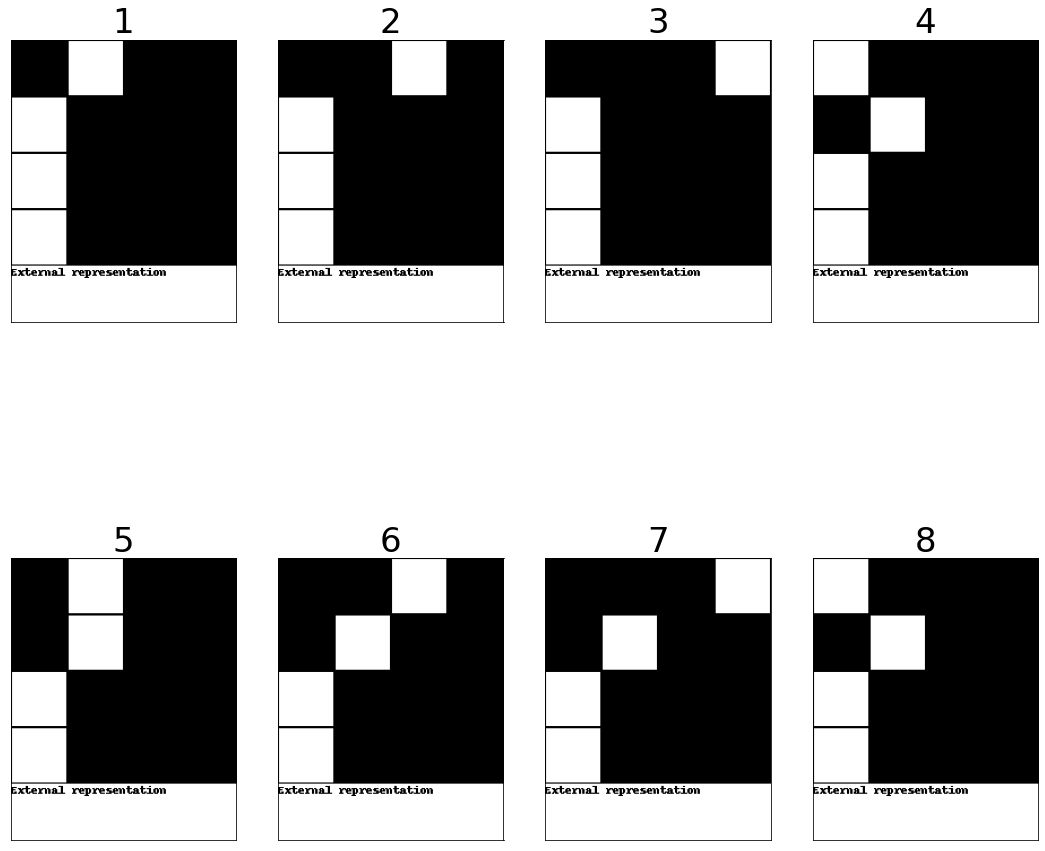

In [62]:
env.reset()
#display(env.render(), display_id='model_demo')
grid_width = 4
grid_height = 2
fig, axs = plt.subplots(grid_height, grid_width,figsize=(15,15))
fig.tight_layout()

mv_str = 'move_token_right'
action_list = [mv_str, mv_str, mv_str, mv_str, 'down', mv_str, 'up', mv_str, mv_str, mv_str, mv_str]
j_repr = -1
    
for i in range(agent_params['max_episode_length']+3):
    #env.step(['right', 'mod_point'])
    env.step(env.all_actions_dict_inv[action_list[i]])
    #update_display(env.render(), display_id='model_demo')
    #time.sleep(3)
    if(action_list[i]==mv_str and i!=3):
        j_repr += 1
        img = env.render()
        ax = axs[j_repr//grid_width, j_repr%grid_width]
        ax.imshow(env.ext_repr_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(j_repr+1), fontsize=34)
    

plt.subplots_adjust(hspace=0)

In [24]:
env.step(['move_token_right', 'move_token_right'])
update_display(env.render(), display_id='model_demo')

In [18]:
%run SingleAgent.py
%run MultiAgentEnvironment.py
%run utils.py

KeyError: 'Agent_Setup'

In [3]:
agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = SingleRLAgent(agent_params)

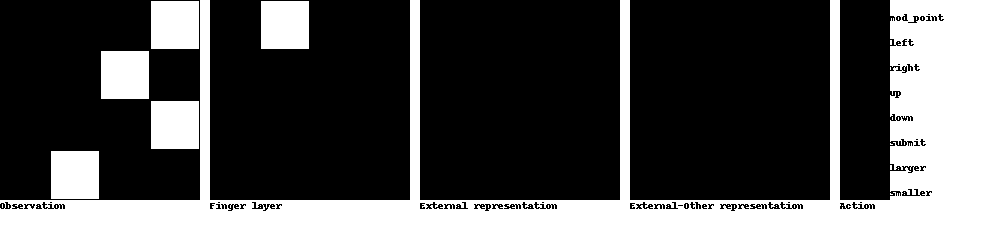

In [4]:
agent.render()

In [26]:
def demonstrate_model(model, env, collect=False, eval=True, n_objects=None):
    total_rewards = []
    summed_rewards = 0

    states = env.reset(n_objects)
    states = torch.stack([torch.unsqueeze(ptu.from_numpy(state), dim=0) for state in states]).transpose(0,1)
    t_sofar = 0
    done = False

    
    actions_during_episode = []
    img_list = []
    img_list.append(env.render(display_id="model_demo"))
    time.sleep(2)

    while not done:
        t_sofar += 1
        actions_tensors = model(states)
        action_arr = [ptu.to_numpy(actions_tensor) for actions_tensor in actions_tensors]
        actions = [np.argmax(action_arr[0], axis=1)[0], np.argmax(action_arr[1], axis=1)[0]]
        actions_during_episode.append(actions)
        next_states, reward, done, _ = env.step(actions)

        # Convert numpy objects to tensors for saving in memory
        reward = torch.tensor([ptu.from_numpy(np.array(reward))])
        actions = torch.stack([torch.unsqueeze(ptu.from_numpy(np.array(action)),dim=0) for action in actions])
        if next_states is not None:
            next_states = torch.stack([torch.unsqueeze(ptu.from_numpy(next_state), dim=0) for next_state in next_states]).transpose(0,1)

        # Move to the next state
        states = next_states


        if done:
            reward = reward.cpu().numpy().item()
            summed_rewards += reward
            total_rewards.append(reward)

        #if(eval and i_episode==0):
        #    print("act ", t_sofar, ": ", actions)
        print(actions)
        img_list.append(env.render(display_id="model_demo"))
        time.sleep(2)
    return img_list



In [9]:
# Define Environment (2-Agents)

agent_params = {
    'max_objects': 2,
    'obs_dim': 4,
    'max_episode_length': 1,
}

# agent_params = {
#     'max_objects': 3,
#     'obs_dim': 4,
#     'max_episode_length': 3,
# }

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
    'max_episode_length': 5,
}

agent_params = {
    'max_objects': 9,
    'obs_dim': 4,
    'max_episode_length': 7,
}

agent_params = {
    'max_objects': 8,
    'obs_dim': 4,
    'max_episode_length': 8,
    'observation': 'spatial'
}




obs_ext_shape = (9,1)

agent_params = {
    'max_objects': 8,
    'obs_shape': obs_ext_shape,
    'ext_shape': obs_ext_shape,
    'max_episode_length': 8,
    'observation': 'spatial',
    'single_or_multi_agent': 'single',
    'external_repr_tool': 'WriteCoord'
}

In [7]:


model_dir = data_dir + 'classify_WriteCoord_spatial_2_to_3_16-08-2021_15-37-38/'
params_file = model_dir + 'params.pickle'
model_file = model_dir + 'best_model.pt'

with open(params_file, 'rb') as f:
    agent_params = pickle.load(f)['agent_params']

agent_params['max_objects'] = 2


env = MultiAgentEnvironment(agent_params)
#env.max_episode_length = 7
env.reset()
ext_shape = env.agents[0].ext_shape
dimmy = 1 if ext_shape[1] == 1 else 2
    
display(env.render(), display_id='model_demo')

n_channels, screen_height, screen_width  = env.states[0].shape  # Assumes that all agents have same state-dim as agent[0]
n_actions = env.agents[0].action_dim
#model = N_Concat_CNNs(n_channels, n_actions, shared_policy=False)
model = N_Concat_CNNs(n_channels, n_actions, shared_policy=True, example_input = env.states, dim=dimmy)
# Successful 2
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_30-04-2021_16-16-33/model.pt'))
# Successful 3
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_11-34-15/model.pt'))
# Successful 4
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_13-03-38/model.pt'))
# almost - Successful 5
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_14-22-02/model.pt'))
# 60 % for 9
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_04-05-2021_13-36-48/model.pt'))
# 82 % for 9
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_04-05-2021_22-08-07/model.pt'))
# Classify to 5 82 %
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_05-05-2021_18-37-48/model.pt'))
# Classify to 5 95 %
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_07-05-2021_11-03-33/model.pt'))
# even more: TODO_07-05-2021_11-32-52
# Reproduce up til 8 objects: 
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_11-05-2021_11-30-16/model.pt'))
model.load_state_dict(torch.load(model_file), strict=False)




img_list = demonstrate_model(model, env, n_objects=[2,3])

FileNotFoundError: [Errno 2] No such file or directory: '/home/silvester/programming/rl-single-agent-numbers/remote/counting-agents/src/../data/classify_WriteCoord_spatial_2_to_3_16-08-2021_15-37-38/params.pickle'

In [38]:
a = np.zeros((4, 4))
a.ravel()[np.random.choice(4*4, 8, replace=False)] = 1
print(a)
print(a.sum())

[[1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 1.]]
8.0


In [135]:
test_dict = {
    0: '0',
    1: '1',
    2: '2',
}
len(test_dict)

3

In [56]:
interact(img_slider,t=(0, len(img_list)-1, 1));

interactive(children=(IntSlider(value=2, description='t', max=4), Output()), _dom_classes=('widget-interact',)…

In [70]:
imageio.mimsave('../results/animations/comparison_up_3_2_vs_3.gif', img_list, duration=2)

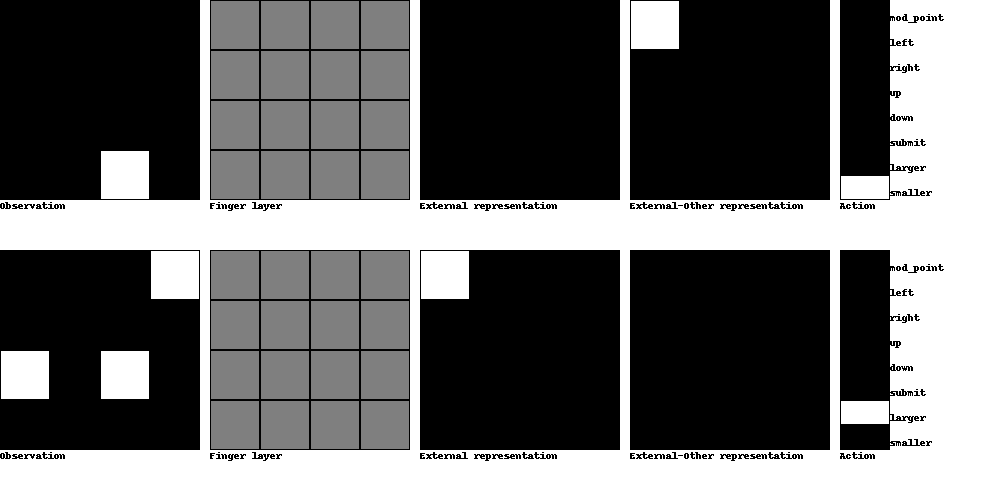

In [43]:
def img_slider(t):
    display(img_list[t], display_id="slider_display")
    
img_slider(0)


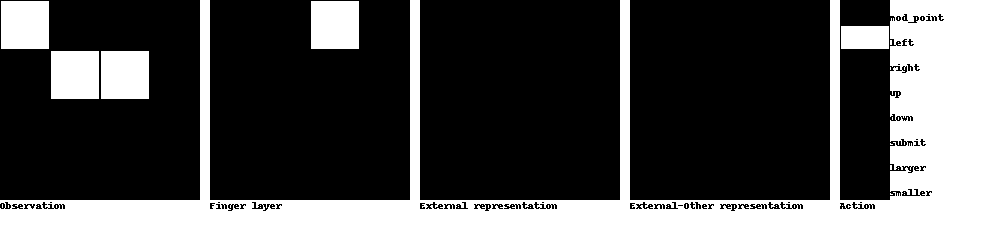

In [5]:
action = 'left'
agent.step(action)
agent.render()

In [10]:
### Create a gif with sample actions
import imageio
import time

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = SingleRLAgent(agent_params)
display(agent.render(), display_id="demo")

images = []
images.append(agent.render())

n_steps = 5
for i in range(n_steps):
    action = n_steps-i-1 #random.randint(0, agent.action_dim-1)
    agent.step(action)
    agent.render(display_id="demo")
    time.sleep(1)
    #images.append(agent.render())
#imageio.mimsave('env_demo_2.gif', images, fps=0.5)

KeyError: 'single_or_multi_agent'

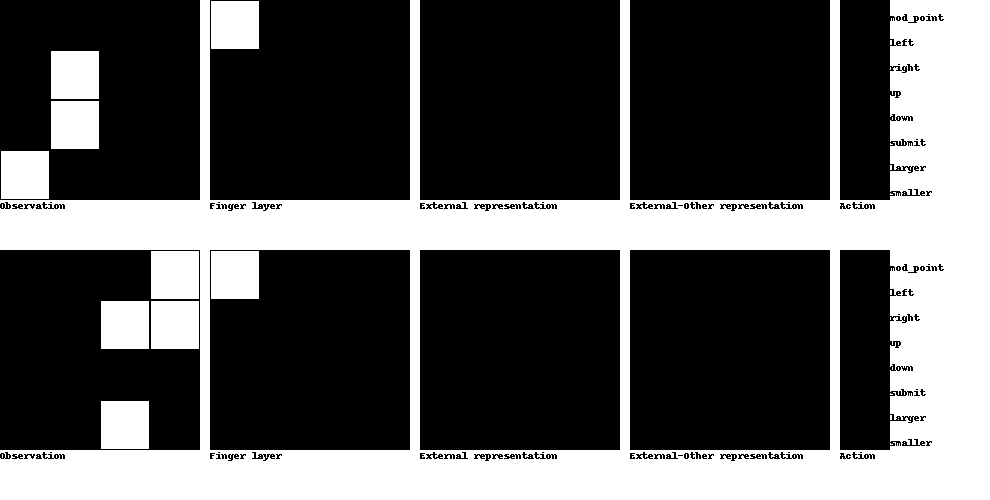

In [3]:
### Create a gif with sample actions
import imageio
import time

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = MultiAgentEnvironment(agent_params)
agent.render()

# images = []
# images.append(agent.render())

# n_steps = 5
# for i in range(n_steps):
#     action = n_steps-i-1 #random.randint(0, agent.action_dim-1)
#     agent.step(action)
#     plt.show(agent.render(display_id="demo"))
#     time.sleep(1)
#     images.append(agent.render())

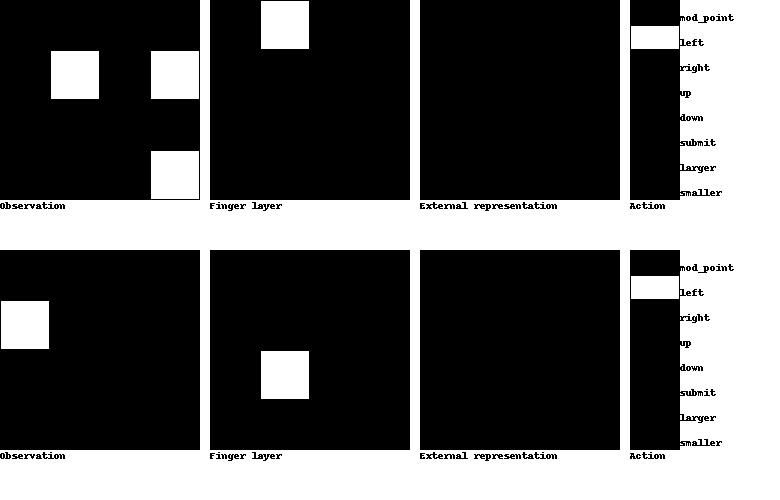

Reward:  0
Done:  True


In [11]:
_, reward, done, _ = agent.step(['left', 'left'])
display(agent.render(), display_id='game')
print("Reward: ", reward)
print("Done: ", done)

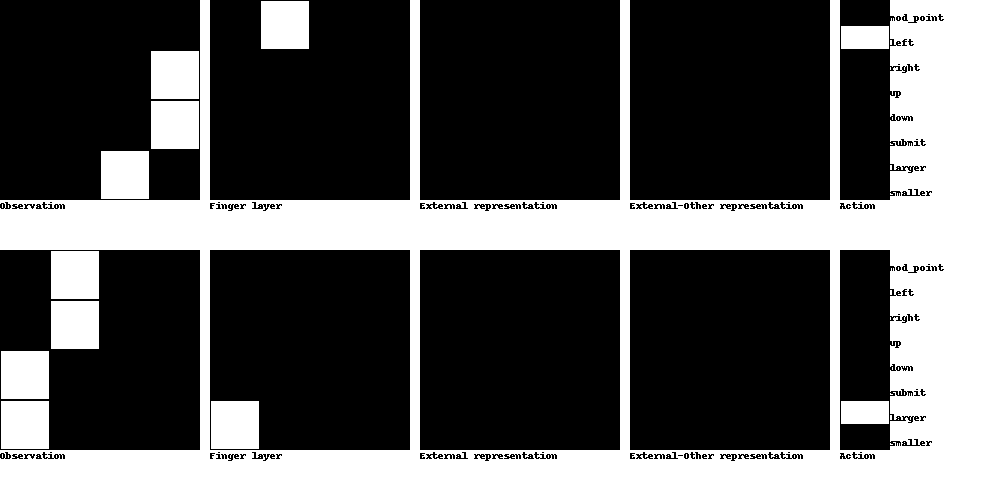

Reward:  0
Done:  False
Reward:  0
Done:  False
Reward:  1
Done:  True


In [9]:
action_list = [['left', 'left'], ['smaller', 'left'], ['left', 'larger']]
display(agent.render(), display_id='multi_game')

for action in action_list:
    _, reward, done, _ = agent.step(action)
    img = agent.render(display_id="multi_game")
    time.sleep(1)
    print("Reward: ", reward)
    print("Done: ", done)

In [14]:
action = ['mod_point', 'left']
_, reward, done, _ = agent.step(action)
img = agent.render(display_id="multi_game")

In [48]:
n_range = np.arange(1, 4+1)
print("n_range: ", n_range)

n_objects = np.random.choice(n_range, 2, replace=False)
print(n_objects)

n_range:  [1 2 3]
[1 2]


In [26]:
env.max_episode_length

3

In [4]:
def funcy():
    print("here we go")

def funcy2():
    print("here we go 2")
    
class ExperimentSetup():
    def __init__(self, func_i):
        
        self.vari = 0
        self.incry()
        self.reward_funcy = func_i

    def reward_function(self):
        self.reward_funcy()
    def env_update(self):
        pass
    def update_state(self):
        state = np.stack([self.obs, self.fingerlayer.fingerlayer, self.ext_repr.externalrepresentation])
        return state
    
    def incry(self):
        self.vari += 1

In [3]:
def iteraty():
    l = 2
    for i in range(10000000):
        l += 1

In [4]:
import cProfile
cProfile.run('iteraty()')

         4 function calls in 0.392 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.392    0.392    0.392    0.392 <ipython-input-3-ebc7f820c210>:1(iteraty)
        1    0.000    0.000    0.392    0.392 <string>:1(<module>)
        1    0.000    0.000    0.392    0.392 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [42]:
for n in range(6):
    print(random.randint(2,3))

3
2
2
2
2
2


In [18]:
def calc_event_timesteps(n_objects):
    big_timestep_range_from_n = 5
    small_timestep_range = [1,2]
    big_timestep_range = [2,3]
    timestep_range = small_timestep_range

    event_timesteps = []
    t_n = 0

    for n in range(1,n_objects+1):
        if(n==big_timestep_range_from_n):
            timestep_range = big_timestep_range
        t_n += random.randint(timestep_range[0],timestep_range[1])
        event_timesteps.append(t_n)
        
    return event_timesteps
    
def calc_max_episode_length(n_objects, observation):
    if(observation == 'spatial'):
        return 1*n_objects-1
    elif(observation == 'temporal'):
        #return 1*n_objects+1

        big_timestep_range_from_n = 5
        max_time_length = min(big_timestep_range_from_n - 1, n_objects) * 2
        # + max(0,max_objects-big_timestep_range_from_n)*3
        if (n_objects >= big_timestep_range_from_n):
            max_time_length += (n_objects - big_timestep_range_from_n+1) * 3
        return max_time_length
    
n_objects = 5
event_timesteps = calc_event_timesteps(n_objects)
max_episode_length = calc_max_episode_length(n_objects, observation='temporal')
print("event_timesteps: ", event_timesteps)
print("max_episode_length: ", max_episode_length)


event_timesteps:  [2, 3, 5, 7, 9]
max_episode_length:  11


In [20]:
ext_repr_imgs = {i: [] for i in range(1, 5)}
print(ext_repr_imgs)
ext_repr_imgs[1].append(5)
print(ext_repr_imgs)

{1: [], 2: [], 3: [], 4: []}
{1: [5], 2: [], 3: [], 4: []}
